<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Johnny Godoy


### **Link de repositorio de GitHub:** `https://github.com/johnny-godoy/laboratorios-mds/blob/main/2023/lab10/laboratorio_10.ipynb`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

C:\Users\David\Desktop\random_projects\laboratorios-mds\venv\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\David\Desktop\random_projects\laboratorios-mds\venv\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\David\Desktop\random_projects\labor

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

In [2]:
df = pd.read_csv("data/input/diabetes_data.csv").drop_duplicates()
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64020 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   64020 non-null  float64
 1   Sex                   64020 non-null  float64
 2   HighChol              64020 non-null  float64
 3   CholCheck             64020 non-null  float64
 4   BMI                   64020 non-null  float64
 5   Smoker                64020 non-null  float64
 6   HeartDiseaseorAttack  64020 non-null  float64
 7   PhysActivity          64020 non-null  float64
 8   Fruits                64020 non-null  float64
 9   Veggies               64020 non-null  float64
 10  HvyAlcoholConsump     64020 non-null  float64
 11  GenHlth               64020 non-null  float64
 12  MentHlth              64020 non-null  float64
 13  PhysHlth              64020 non-null  float64
 14  DiffWalk              64020 non-null  float64
 15  Stroke             

In [4]:
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000
mean,8.607420,0.455983,0.539550,0.973211,30.178554,0.490706,0.159950,0.678366,0.590862,0.771587,0.046345,2.921103,4.130537,6.385020,0.277007,0.068510,0.581756,0.521681
std,2.860717,0.498063,0.498437,0.161466,7.287730,0.499918,0.366563,0.467107,0.491679,0.419813,0.210233,1.107991,8.466301,10.368493,0.447524,0.252621,0.493275,0.499534
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,11.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,7.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


No hay valores faltantes. Los atributos categóricos ya están codificados
numéricamente. Solamente hay jóvenes. Varios atributos son
discretos-ordinales o binarios, lo que sirve para modelos de árboles. El problema
está bien balanceado.

## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

In [5]:
X = df.drop(columns=["Diabetes"])
y = df["Diabetes"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=0,
    stratify=y,
    test_size=0.2,
)

Notamos que todas las variables son numéricas y no hay valores faltantes, por lo que
bastará utilizar `XGBoost` sin un `Pipeline` o `ColumnTransformer`. Se realizará
`GridSearchCV` con 5 folds, y se medirá el _f1 score_ para seleccionar el mejor
modelo. En pruebas con `optuna`, no se logró encontrar mejores hiperparámetros que
los por defecto, por lo que solamente se probará con un rango pequeño de valores
cercanos a los por defecto.

_f1 score_ se escoge debido a que es una medida robusta que balancea la
 precisión y el _recall_ sin tener que pensar mucho más profundamente
en la decisión. Podremos interpretar esta medida como un error total de clasificación.

Para validar el modelo, se verá la matriz de confusión.


In [6]:
gridsearch_root = "output/gridsearch.pkl"
try:
    with open(gridsearch_root, "rb") as f:
        grid = pickle.load(f)
except FileNotFoundError:
    base_clf = xgb.XGBClassifier(random_state=0, n_jobs=5)
    param_grid = {
        "n_estimators": [100, 150, 200],
        "max_depth": [5, 6, 7],
        "learning_rate": [0.15, 0.3, 0.6],
    }
    grid = GridSearchCV(
        base_clf,
        param_grid,
        scoring="f1",
    )
    grid.fit(X_train, y_train)
    with open(gridsearch_root, "wb") as f:
        pickle.dump(grid, f)

Puntajes en validación:

In [7]:
index = grid.best_index_
pd.DataFrame(grid.cv_results_).loc[index]

mean_fit_time                                                   1.027432
std_fit_time                                                     0.19584
mean_score_time                                                 0.015004
std_score_time                                                  0.002098
param_learning_rate                                                 0.15
param_max_depth                                                        5
param_n_estimators                                                   100
params                 {'learning_rate': 0.15, 'max_depth': 5, 'n_est...
split0_test_score                                               0.765355
split1_test_score                                               0.753739
split2_test_score                                               0.767167
split3_test_score                                               0.764041
split4_test_score                                               0.759648
mean_test_score                                    

Vemos que el `f1-score` no es tan alto para lo que queremos (0.76 en promedio), pero
es muy estable (0.004 de desviación estándar). Esto indica que el modelo no está
 sobreajustando a cada _fold_.

Nos interesa más aún saber si este puntaje generaliza bien a datos de prueba, y saber
 si el modelo está sesgado hacia alguna clase:

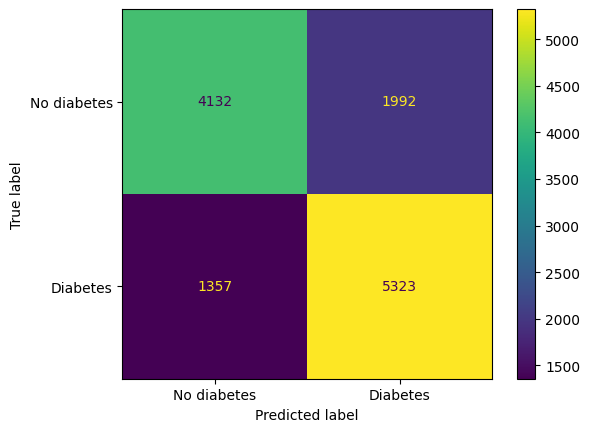

In [8]:
clf = grid.best_estimator_
conf = confusion_matrix(y_test, clf.predict(X_test))
disp = ConfusionMatrixDisplay(conf, display_labels=["No diabetes", "Diabetes"])
disp.plot();

Tanto en los conjuntos validación como en el de prueba, el modelo se equivoca cerca
de 1/4 de las veces en cualquiera de las dos clases. Esto muestra que el modelo no
está sesgado hacia ninguna clase, y que la validación es representativa del error de
generalización en el conjunto de prueba.

El error sí es más alto de lo deseado dado la importancia del problema, pero no se
logró encontrar una mejora simple de implementar.


Con esto, respondemos las preguntas:

* ¿Es acaso un buen predictor de diabetes? R: Muestra un buen puntaje de
clasificación al realizar validación cruzada, pero ésto es solamente un proxy del
error de generalización verdadero. En realidad, no sabemos si los datos
proporcionados son suficientemente representativos de la población de pacientes, y no
 se realizó un EDA para validar que éstos datos permitan una capacidad de generalizar
  para pacientes reales.
* ¿Qué buscan explicar las métricas utilizadas? R: Que el modelo sea capaz de
 clasificar correctamente a los pacientes fuera de la muestra de entrenamiento (pero
 dentro del conjunto de prueba).
* ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su
modelo una buena elección de las features? R: No, solamente determinan que el modelo
es preciso, pero `XGBoost` no realiza una selección de características, y puede
ajustarse al ruido específico de este conjunto de datos. Debido a que utiliza
mecanismos como _column subsampling_, el modelo
puede terminar utilizando características inútiles, y estará sesgado hacia utilizar
más frecuentemente características repetidas.

## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

 Se crea cada uno de los gráficos de importancia de características.

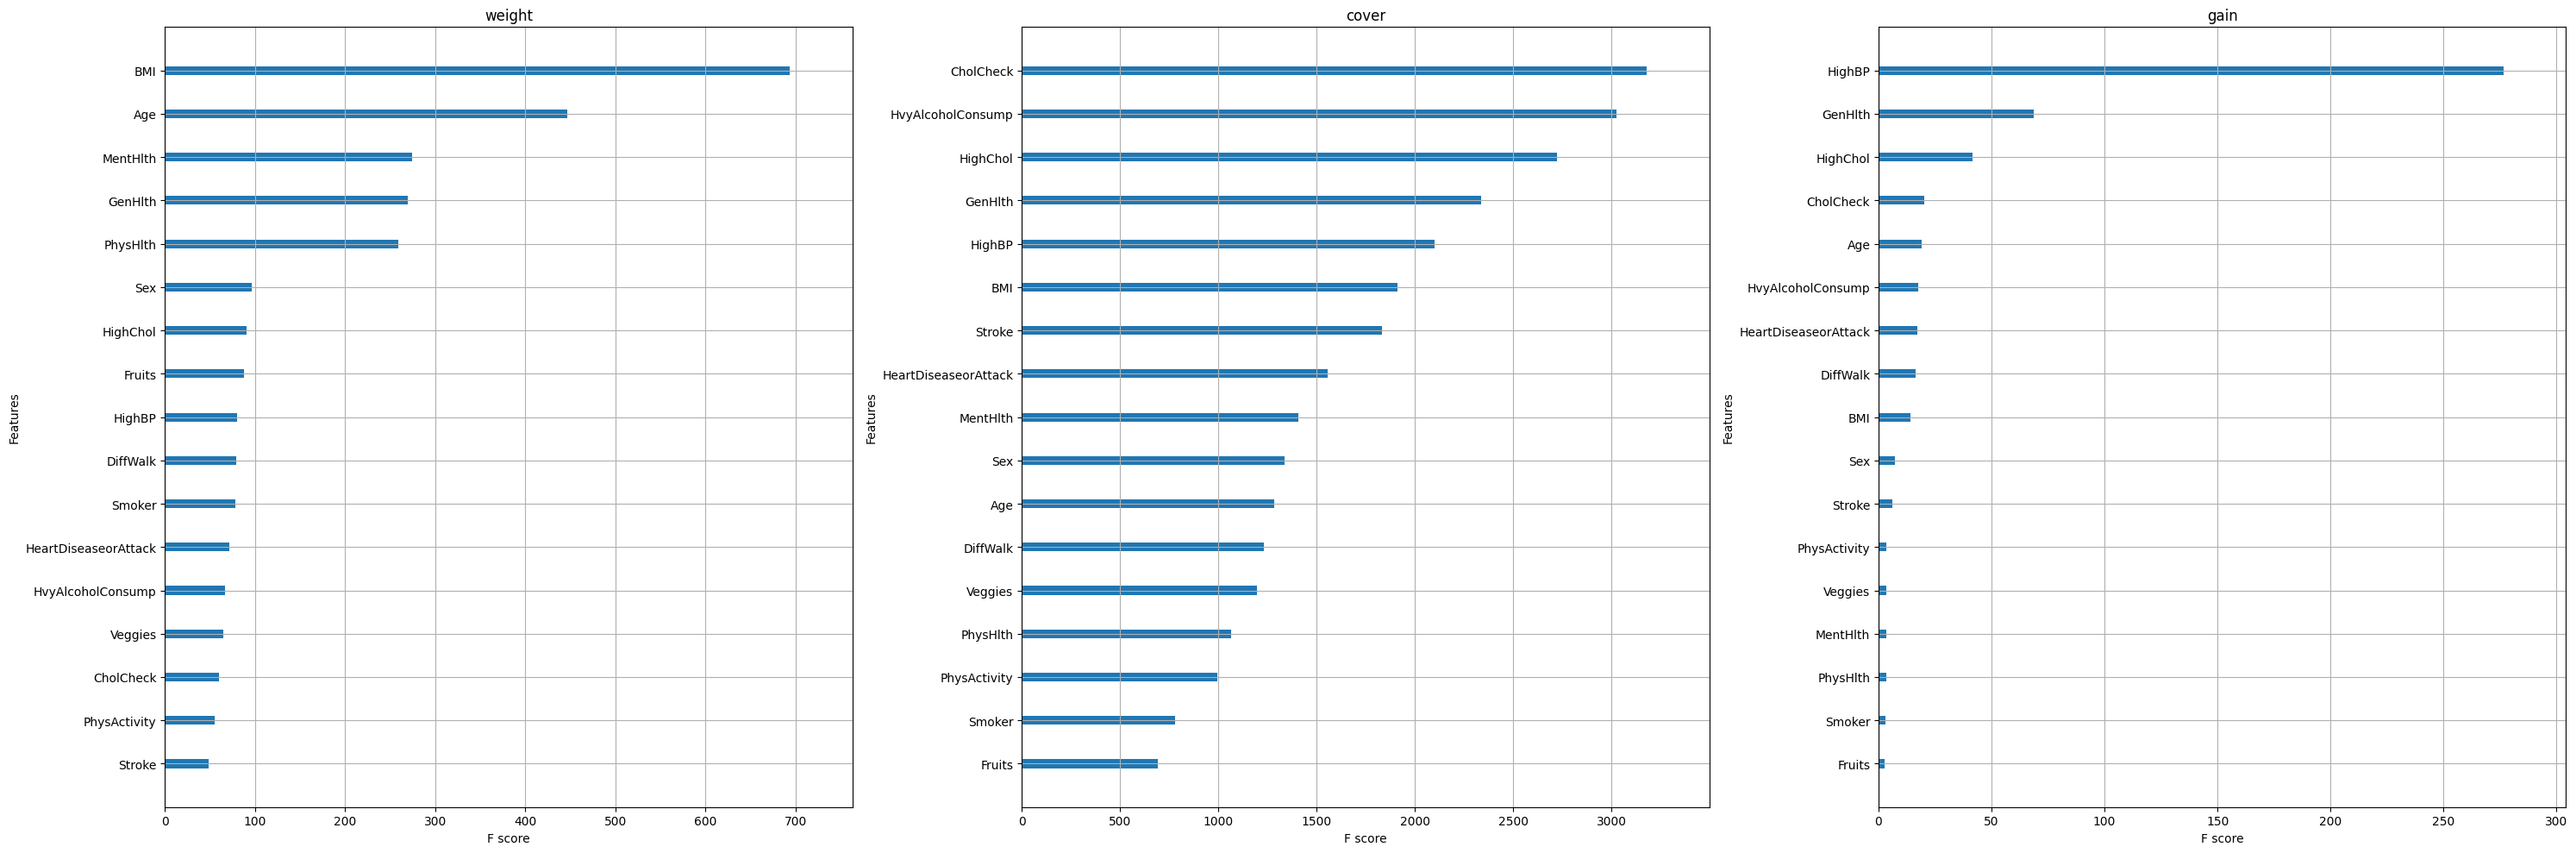

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
importance_types = ("weight", "cover", "gain")
for method, ax in zip(importance_types, axes):
    xgb.plot_importance(
        clf, importance_type=method, title=method, ax=ax, show_values=False
    )
plt.tight_layout()

Para responder respecto a la consistencia, se creará un gráfico que compare la
posición de ranking de cada característica en cada método, conectando con una línea
las posiciónes de cada característica en cada método. Líneas horizontales indicarían
que ambos métodos coinciden en ranking, pero estas no se dibujarán por claridad. Es
decir, la presencia de una línea en el gráfico indica un desacuerdo en el ranking de
distintos métodos. Líneas más largas indican un mayor desacuerdo.

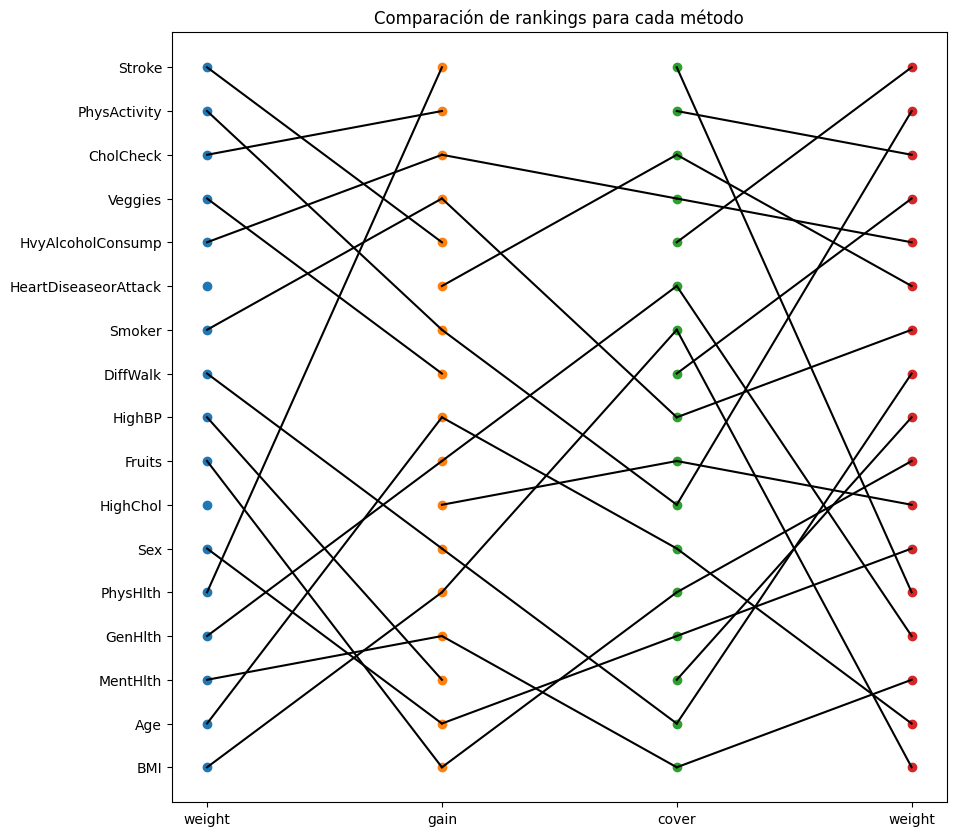

In [10]:
booster = clf.get_booster()
importances = {
    method: pd.Series(booster.get_score(importance_type=method))
    .sort_values(ascending=False)
    .index
    for method in importance_types
}
weight = importances["weight"]
x = np.zeros_like(weight, dtype=np.float32)
ns = np.arange(len(weight))
fig, ax = plt.subplots(figsize=(10, 10))
for i, method in enumerate(importance_types):
    ax.scatter(x + i, ns, marker="o")
ax.scatter(x + len(importance_types), ns, marker="o")

weight_indices = np.arange(len(weight))
gain_indices = importances["gain"].values.argsort()
cover_indices = importances["cover"].values.argsort()

weight_gain_mask = weight_indices != gain_indices
gain_cover_mask = gain_indices != cover_indices
cover_weight_mask = cover_indices != weight_indices

ax.plot(
    [0, 1],
    np.column_stack((weight_indices, gain_indices))[weight_gain_mask].T,
    color="k",
)
ax.plot(
    [1, 2], np.column_stack((gain_indices, cover_indices))[gain_cover_mask].T, color="k"
)
ax.plot(
    [2, 3],
    np.column_stack((cover_indices, weight_indices))[cover_weight_mask].T,
    color="k",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax.set_yticklabels(weight)
    ax.set_yticks(ns)
    ax.set_xticklabels(["weight", "gain", "cover", "weight"])
    ax.set_xticks([0, 1, 2, 3])
ax.set_title("Comparación de rankings para cada método");

Se puede observar muchas líneas, y líneas con gran pendiente, indicando que los
rankings son muy inconsistentes.

Este desacuerdo se explica porque cada importancia mide algo distinto. Según la
documentación de `XGBoost`:

* ”weight” is the number of times a feature appears in a tree

* ”gain” is the average gain of splits which use the feature

* ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

Que no necesariamente coinciden, pero las tres están relacionadas por como los
árboles utilizan la característica para realizar las particiones. Esto significa que
existe un sesgo por características que tienen más valores únicos, pues hay más
chances para dividirse.

Sin embargo, sí hay algunos acuerdos generales:
* `CholCheck` siempre es una de las características más importantes (sus puntos están
 arriba en el gráfico)
* `MentlHlth` siempre es una de las características menos importantes (sus puntos
 están abajo en el gráfico)
* `PhysHlth` y `Stroke` tienen mucha variabilidad en los ranking (líneas largas)


Para responder las otras preguntas planteadas:

* ¿Las importancias obtenidas son suficientes para obtener la interpretabilidad de un
 modelo que utiliza árboles? R: No, solamente tenemos una indicación global (y
 sesgada) de la importancia de cada característica, pero no podemos reconstruir cómo
 el modelo toma las decisiones, cómo se puede para un árbol de decisión, que se puede
  graficar de una manera que permite interpretabilidad global (viendo la estrcutura
  del árbol) y local (siguiendo un camino hacia una hoja), ambas exactas.
* ¿Qué debilidad presenta este método? R: La interpretación es inexacta, sesgada.
  No indica signos, es decir, si una característica aumenta o disminuye la
  probabilidad de diabetes. Esconde la relacíón con la distribución de cada variable
  (en particular, valores únicos). No permite reconstruir el modelo.

## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

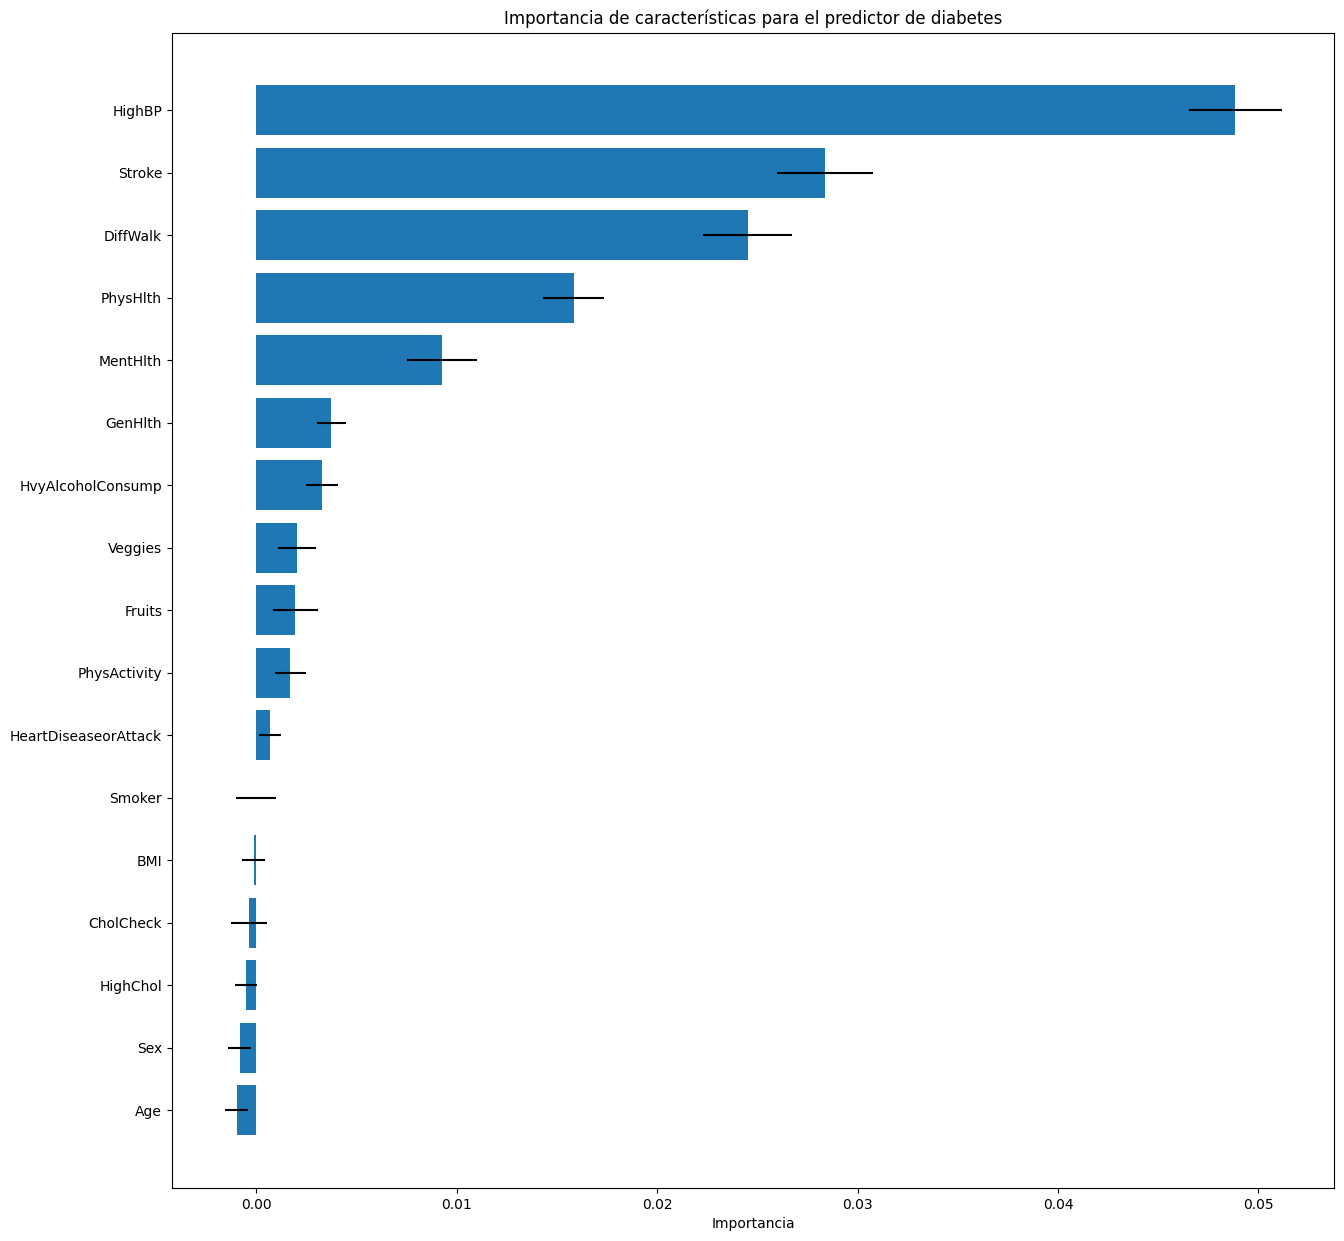

In [11]:
perm_importance = permutation_importance(
    clf, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1
)
perm_importance_df = pd.DataFrame(
    {
        "importances_mean": perm_importance.importances_mean,
        "importances_std": perm_importance.importances_std,
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=True)
plt.figure(figsize=(15, 15))
plt.barh(
    range(X.shape[1]),
    perm_importance_df.importances_mean,
    xerr=perm_importance_df.importances_std,
)
plt.yticks(range(X.shape[1]), X.columns)
plt.title("Importancia de características para el predictor de diabetes")
plt.xlabel("Importancia")

Respondiendo lo pedido:

* La desviación estándar indica la variabilidad de los resultados, pues la
permutación es aleatoria. Si bien se espera que en principio las permutaciones deben
empeorar los resultados, por la aleatoriedad puede haber casos en que mejoren. En
este caso, la mayoría de importancias tiene una desviación estándar baja, lo que
muestra que el método es consistente.
* La importancia de una característica se mide como la pérdida de
puntaje que incurre el modelo al permutar los valores de una característica.
* Las 5 características de mayor impacto al modelo son:
- `HighBP` (presión sangínea alta)
- `Stroke` (si tuvo un ataque cerebrovascular)
- `DiffWalk` (dificultad para caminar)
- `PhysHealth` (puntaje de salud física)
- `MentHealth` (puntaje de salud mental)
* Todas éstas tienen que ver con la salud, y tiene sentido que se correlacionen con
la diabetes. Es importante destacar que no necesariamente implican una relación
causal. Consultando con un médico, se verificó que si bien se conoce de la relación
entre los ataques cerebrovasculares y la diabetes, no se ha determinado una
causalidad desde la fisiopatología. El único caso donde se puede afirmar que hay una
relación causal es en la dificultad para caminar, pues esta causa sedentarismo.
* Existen dos diferencias muy grandes a las importancias anteriores: `CholCheck` se
considera dañino para el modelo (importancia negativa), y `MentlHlth` se considera
muy buen predictor. Esto no es explicado por la cantidad de valores únicos que tiene
cada variable, pues `CholCheck` tiene 2 y `MentlHlth` tiene 31 valores. Sin embargo,
sí se puede explicar porque ahora las interacciones sí se toman en cuenta.
* Ventajas: Este modelo toma en cuenta interacciones. Logra una mejor interpretación
global en términos del error del modelo, sin requerir reentreanamiento. Más aún, es
agnóstico y comparable entre modelos.
* Desventajas: El error está enlazado al error del modelo. Caracerísticas
correlacionadas pueden causar sesgos, pues las permutaciones no deberían ser
independientes para generar datos de la distribución original. Como la importancia se
 divide en todas las características correlacionadas, si hay varias entonces se
 diluye la importancia de cada una.

In [12]:
X.nunique().sort_values(ascending=False)

BMI                     80
PhysHlth                31
MentHlth                31
Age                     13
GenHlth                  5
Veggies                  2
Stroke                   2
DiffWalk                 2
HvyAlcoholConsump        2
Fruits                   2
Sex                      2
PhysActivity             2
HeartDiseaseorAttack     2
Smoker                   2
CholCheck                2
HighChol                 2
HighBP                   2
dtype: int64

## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [13]:
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [16]:
shap_explain = shap.TreeExplainer(clf)

### Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [ ]:
# Inserte código para generar gráficos de aporte local aquí

### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

In [ ]:
# Inserte código para generar gráficos de aporte global aquí

### Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [ ]:
# Inserte código para generar gráficos de feature vs shap value aquí

### Parte E (0.4 pt)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [ ]:
# Inserte código para generar gráficos PDP aquí

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
# Inserte su código para generar sistema de reglas aquí

idx = 1000
# explicar predicción idx 1000

idx = 3001
# explicar predicción idx 3001

idx = 5751
# explicar predicción idx 5751

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>